# An exploration of the Happiness Index, Suicide Rates and Alcohol Consumption
The following data science code is exploring the Happiness Index and overlaying it with Suicide Rates and Alcohol Consumption.

It then tries to find correlating factors in the data sets.

As it turns out there are some strange anomolies of highly suicidal countries also being among the happiest - while having high alcohol consumptions.

## Starting by setting up the data science environment in Python
...and loading the Happiness report dataset from 2019. The data set is downloaded from Kaggle.com

Further setup:
- Jupyter Notebook running Python 3.7
- Numpy, Pandas, Matplotlib, Fuzzywuzzy, Seaborn, Geopandas modules are used


## Exploring the data
We want to see top 5 countries, column names of data offered and quickly use this for Correlation Coefficient matrix plot to see if any variables in the dataset itself could be used as correlating explanation for happiness. It isn't expected as it would be strange if there were linearly coupled factors to happiness.

However, one could argue GDP, lack of corruption and social cohesion as plausible explanatory factors of happiness - so let's see.

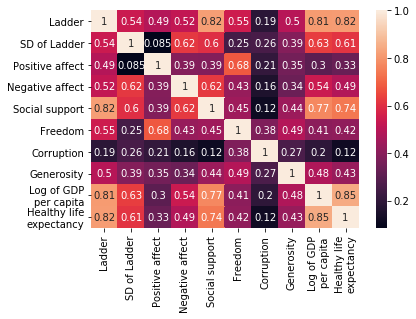

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from mpl_toolkits.basemap import Basemap
import matplotlib.animation as animation
import itertools
import geopandas as gpd
from descartes import PolygonPatch
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

%matplotlib inline

# Load Happiness index - see for correlations if any?
happy = pd.read_csv('./data/world-happiness-report-2019.csv')
happycorr = happy.corr('pearson')
sns.heatmap(happycorr, annot=True)



# Correlations
The Happiness Index is strongly correlated to GDP (0.81), Life Expectancy (0.82) and Social Support (0.82). Correlates below 0.80 are not taken into consideration for immediate discussion. There are no inverse correlates.

GDP itself is strongly correlated with social support, and life expectancy ie. a good social and health system, so there seem to be a circular loop: what comes first?

## Are Happy nations people less likely to commit suicide?
Now let's check if happy nations are also less likely to commit suicide? As suicide could be used as a measurement of unhappiness.

In other words - are happy nations also not unhappy?

Starting by loading the WHO Suicide data set and doing the same initial data exploration, data obtained from Kaggle and WHO.

The data set doesn't have a normalized suicide per capita column, so I create that immediately on the fly with a lambda function exploiting Pandas vector/matrix abilities to avoid looping through the data.

### Loading and exploring the WHO suicide data

In [27]:
# not containing African data .. needs updating ... see later
# data from WHO and Kaggle
suicide = pd.read_csv('./data/who_suicide_statistics.csv')
# print(suicide[suicide['country'].str.contains('Russia')])

# drop NaN suicide rows 
suicide = suicide.dropna()
print(suicide.head())

# Create suicides per capita for each year and age group so we can compare nations suicide rates
suicide['suicidecap'] = suicide.apply(lambda row: row['suicides_no'] / row['population'], axis=1)

# suicide per cap is measured in 100,000 persons by "industry" standard
suicide['suicidecap'] = suicide['suicidecap']*100000
#suicide.plot(kind='density', subplots=True, layout=(2,2), sharex=False, figsize=(8,8))
#plt.show()

# Suicides with African data from World in numbers
# -- whitespace in values due to excel or something...
# so we skid that with skipinitialspace; thanks Pandas!
df = pd.read_csv('./data/xmart.csv', skipinitialspace=True)

# Its a bit rough to drop all NaN rows, rather we should
# only drop where suicides are NaN
# df = df.dropna()
df = df.dropna(subset=['2016', '2015', '2010', '2000'])

#df_sex = pd.get_dummies(df['Sex'])
#df = pd.concat([df, df_sex], axis=1)
print(df.head())

#df=df.loc[df['Sex'] == 'Both sexes']

#df['suicidecap'] = df.apply(lambda row: row['suicides_no'] / row['population'], axis=1)
#suicide['suicidecap'] = suicide['suicidecap']*100000
#suicide.plot(kind='density', subplots=True, layout=(2,2), sharex=False, figsize=(8,8))
#plt.show()

# WHO's entire data set
# containing African data but very heavy dataset
# commented out as we got the Kaggle data above
#sc2 = pd.read_csv('./data/Morticd10_part1', low_memory=False)
#sc1 = pd.read_csv('./data/Morticd10_part2', low_memory=False)
#sc3 = pd.read_csv('./data/icd9', low_memory=False)
#sc2 = pd.concat([data1, data2], ignore_index=True)
#sc4 = pd.concat([sc1, sc2, sc3])
#sc4 = pd.concat([sc1, sc2])
#sc4 = sc4.drop(['Frmat','IM_Deaths1','IM_Deaths2','IM_Deaths3','IM_Deaths4','IM_Frmat', 'Admin1', 'SubDiv', 'List'], axis=1)
#for i in range(2,27) :
#    drop="Deaths"+str(i)
#    sc4 = sc4.drop([drop], axis=1)
#
#sc4 = sc4[sc4.Cause == '1101' | sc4.Cause == 'B40']
#sc4 = sc4[(sc4['Cause'] =='1101') | (sc4['Cause'] =='B40')]

#ccodes = pd.read_csv('./data/country_codes.csv')

# Merge the two data sets
#sc4 = pd.merge(sc4, ccodes, left_on = ['Country'], right_on = ['country'])
#sc4 = pd.DataFrame(sc4)
#print(sc4.head())
#print(sc4.info())
#
#print(sc4.loc[sc4['name'] == 'Nigeria'])
#
#countries = sc4.groupby('name')['Deaths1'].sum()
#countries = pd.DataFrame(countries)
#countries = countries.sort_values(by=['Deaths1'], ascending=False) 
#print(countries)

    country  year     sex          age  suicides_no  population
24  Albania  1987  female  15-24 years         14.0    289700.0
25  Albania  1987  female  25-34 years          4.0    257200.0
26  Albania  1987  female  35-54 years          6.0    278800.0
27  Albania  1987  female   5-14 years          0.0    311000.0
28  Albania  1987  female  55-74 years          0.0    144600.0
       Country         Sex  2016  2015  2010  2000
0  Afghanistan  Both sexes   6.4   6.6   7.4   8.1
1  Afghanistan        Male  10.6  10.9  12.5  14.3
2  Afghanistan      Female   2.1   2.1   2.1   1.7
3      Albania  Both sexes   5.6   5.3   7.7   5.8
4      Albania        Male   7.0   6.7   9.5   8.2


## Lets check the suicide per 100k capita distribution
Followed by plotting suicide per 100k capita against age groups, gender and location.

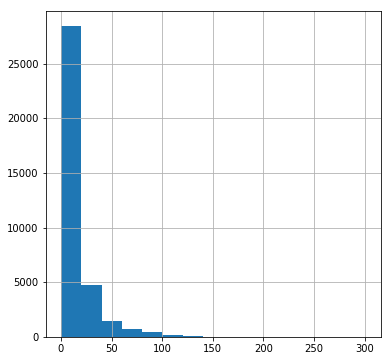

In [4]:
# exploring distribution of suicide per capita age group and year
suicide['suicidecap'].hist(bins=15, figsize=(6,6))
plt.show()

## Distribution of Suicides
We see that by far most nations / observations are in the 0-10 suicides per 100,000. We must not forget that the plot is made directly on dataframe suicide which has the observations broken out in rows by age groups, so the aggregate distribution per country would be slightly higher. We will see this shortly.

## Exploring suicides by year

count        38.000000
mean     210485.973684
std       52278.086833
min       16238.000000
25%      186488.750000
50%      230892.500000
75%      243962.750000
max      259376.000000
Name: suicides_no, dtype: float64


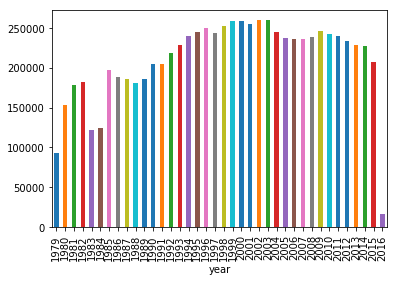

In [5]:
# Lets first understand the data - suicides per year seems reasonable
# Exploring by year and later by country and gender
suicideby = suicide.groupby('year')['suicides_no'].sum()

print(suicideby.describe())
suicideby.plot.bar()
plt.show()

#2016 incomplete year, so we drop that
suicide = suicide[suicide.year != 2016]
suicideby = suicide.groupby('year')['suicides_no'].sum()

# What happened in 1983?
That's the first mystery - lack of data - or some event? And why are there less suicides post 2000?

# Exploring suicides by gender exploration
We map accumulated suicides against gender and we transform the gender categories to a dummy variable so it can be used for Pearson correlation coefficient.

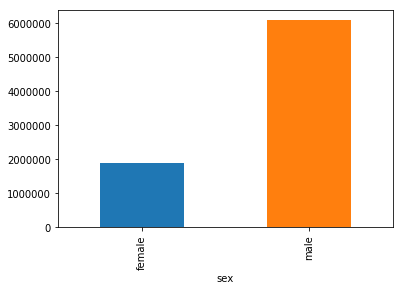

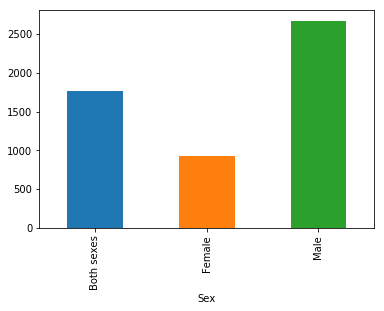

In [6]:
# Exploring suicide by gender
suicidesex = suicide.groupby('sex')['suicides_no'].sum()
#print(suicidesex.describe())
suicidesex.plot.bar()
plt.show()


dfsex = df.groupby('Sex')['2016'].sum()
#print(dfsex.describe())
dfsex.plot.bar()
plt.show()



# Gender is an explaining factor for suicide
As demonstrated, men are more likely to commit suicide through out their life.

# Now let's check for clustered age groups
I will do two analysis:
- Pearson against dummy variable creation out of the offered age groups and plotting that.
- Histogram plots for each age



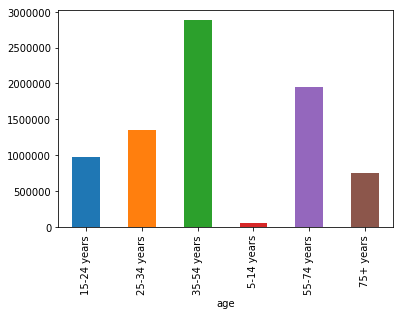

In [7]:
# Count by age
suicideage = suicide.groupby('age')['suicides_no'].sum()
suicideage.plot.bar()
plt.show()

# Suicide is prevalent with the 35-54 year olds
Is that the age when the hopes of the youth gets wasted and reality sinks in?

# Now exploring suicides by country as explaining factor

                    suicidecap
country                       
Lithuania            38.699273
Hungary              35.079436
Sri Lanka            33.017981
Russian Federation   32.527773
Latvia               30.312302
Slovenia             28.569105
Belarus              28.556973
Estonia              28.502512
Kazakhstan           25.981945
Ukraine              24.661982
Finland              23.899487
Austria              21.707493
Japan                21.550616
Croatia              21.415179
Belgium              21.236132


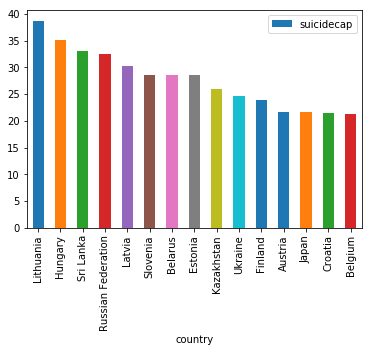

               Country         Sex  2016  2015  2010  2000
210             Guyana  Both sexes  30.2  30.3  29.3  26.7
279            Lesotho  Both sexes  28.9  28.5  27.6  26.8
402             Russia  Both sexes  26.5  27.5  34.5  47.5
288          Lithuania  Both sexes  25.7  28.8  31.3  46.3
465           Suriname  Both sexes  23.2  24.4  28.3  26.4
117      Cote d'Ivoire  Both sexes  23.0  22.8  20.7  16.5
255         Kazakhstan  Both sexes  22.8  25.2  32.0  34.9
156  Equatorial Guinea  Both sexes  22.0  22.0  22.2  21.2
42             Belarus  Both sexes  21.4  21.2  31.9  38.7
393        North Korea  Both sexes  20.2  21.4  28.1  14.2
507             Uganda  Both sexes  20.0  20.2  21.8  22.8
87            Cameroon  Both sexes  19.5  19.6  18.7  21.3
546           Zimbabwe  Both sexes  19.1  18.9  20.6  21.7
510            Ukraine  Both sexes  18.5  19.0  22.6  32.0
357            Nigeria  Both sexes  17.3  17.5  18.2  18.5


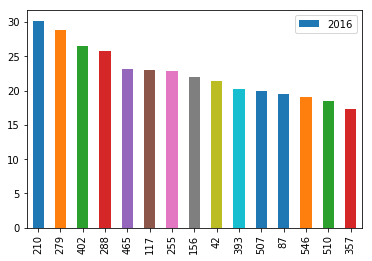

In [28]:
# Correct way is sum up suicides and populations by year -- this drops the previous suicidecap
scc = suicide.groupby(['country','year'])['suicides_no', 'population'].sum()
scc = pd.DataFrame(scc)

# Then calculate suicide per capita in each country per year
# this is also the observations to look at for the aggregate 
# distribution
scc['suicidecap'] = scc.apply(lambda row: row['suicides_no'] / row['population'], axis=1)
scc['suicidecap'] = scc['suicidecap'] * 100000
    
# We could now talk about a mean suicide per capita as sum of suicide cap / observervations per country/year
# this gives a pandas series which we convert to a dataframe
sccd = scc.groupby('country')['suicidecap'].mean()
sccd = pd.DataFrame(sccd)
sccd = sccd.sort_values(by=['suicidecap'], ascending=False) 
print(sccd.head(15))
sccd.head(15).plot.bar(y='suicidecap')
plt.show()

# Doing the same for Kaggle data with African nations
# As we already have Both Sexes column aggregate data
# we just slice by that
df=df.loc[df['Sex'] == 'Both sexes']
dfc = df.sort_values(by=['2016'], ascending=False) 
print(dfc.head(15))
dfc.head(15).plot.bar(y='2016')
plt.show()

# Are there countries that are outliers for suicide?
# Aggregating all years, populations into one pseudo suicide per capita
#suicidecountry = suicide.groupby('country')['suicides_no', 'population'].sum()
#suicidecountry['suicidecap'] = suicidecountry.apply(lambda row: row['suicides_no'] / row['population'], axis=1)
#suicidecountry = suicidecountry.sort_values(by=['suicidecap'], ascending=False) 
#suicidecountry=suicidecountry.rename_axis('country').reset_index()
#print(suicidecountry.head(15))
#suicidecountry.plot.bar(y='suicidecap')
#plt.show()

# By comparing we see that the psuedo suicide per capita and the mean are close enough that we dont care about this
# However it could be cool to plot an animated map and see how things might have changed over time?

# Country outliers ... 
We now see that some countries are suicidal by an order of multiples compared to the mean. What are the correlates? Poverty? Stress? Corruption? Or something else? Let's explore...


## Plot geomap distribution of suicides
With an assumption that perhaps geographic location could explain suicide rates? A geoplot will show clusters if any of suicide rates.

First we load lat/lon coordinates and merge into countrieswithsuicide dataframe

Second we plot these lat/lons with their suicide per capita as weight.

In [9]:
# This is old stuff the I keep to remember how to do means on dataframes
# Lets get only the countries with an above mean suicide rate
# to see if there's an immediate pattern?
#meansuicide = suicidecountry['suicidecap'].mean()
#countries = suicidecountry.where(suicidecountry['suicidecap'] > meansuicide)
#countries = countries.dropna()
#c = countries.sort_values(by='suicidecap', ascending=False)

# Load countries lat / lon to plot suicide on map
countrycodes = pd.read_csv('./data/countries.csv')
#print(sccd.head())

# Merge the two data sets
countrieswithsc = pd.merge(sccd, countrycodes, left_on = ['country'], right_on = ['name'])

dfc = pd.merge(df, countrycodes, left_on = ['Country'], right_on = ['name'])
print(dfc[dfc['Country'].str.contains('Russia')])

print(dfc.head())

print(countrieswithsc.head())

# test for data integrity - all countries have a location
df1 = countrieswithsc[countrieswithsc.isna().any(axis=1)]
print(df1)
df3 = countrieswithsc.loc[~countrieswithsc['name'].isin(countrycodes['name'])].copy()
print("countries not in suicide dataframe but location exists:")
print(df3[['name','suicidecap']])
#no problems check yourself:

# manually comparing the two datasets inside the new dataframe
#print(countrieswithsc[['name','name']])

Empty DataFrame
Columns: [Country, Sex, 2016, 2015, 2010, 2000, country, latitude, longitude, name]
Index: []
               Country         Sex  2016  2015  2010  2000 country   latitude  \
0          Afghanistan  Both sexes   6.4   6.6   7.4   8.1      AF  33.939110   
1              Albania  Both sexes   5.6   5.3   7.7   5.8      AL  41.153332   
2              Algeria  Both sexes   3.3   3.4   3.5   4.7      DZ  28.033886   
3               Angola  Both sexes   8.9   9.3  10.4  13.9      AO -11.202692   
4  Antigua and Barbuda  Both sexes   0.5   0.8   0.2   2.1      AG  17.060816   

   longitude                 name  
0  67.709953          Afghanistan  
1  20.168331              Albania  
2   1.659626              Algeria  
3  17.873887               Angola  
4 -61.796428  Antigua and Barbuda  
   suicidecap country   latitude   longitude                name
0   38.950782      LT  55.169438   23.881275           Lithuania
1   35.518518      HU  47.162494   19.503304             

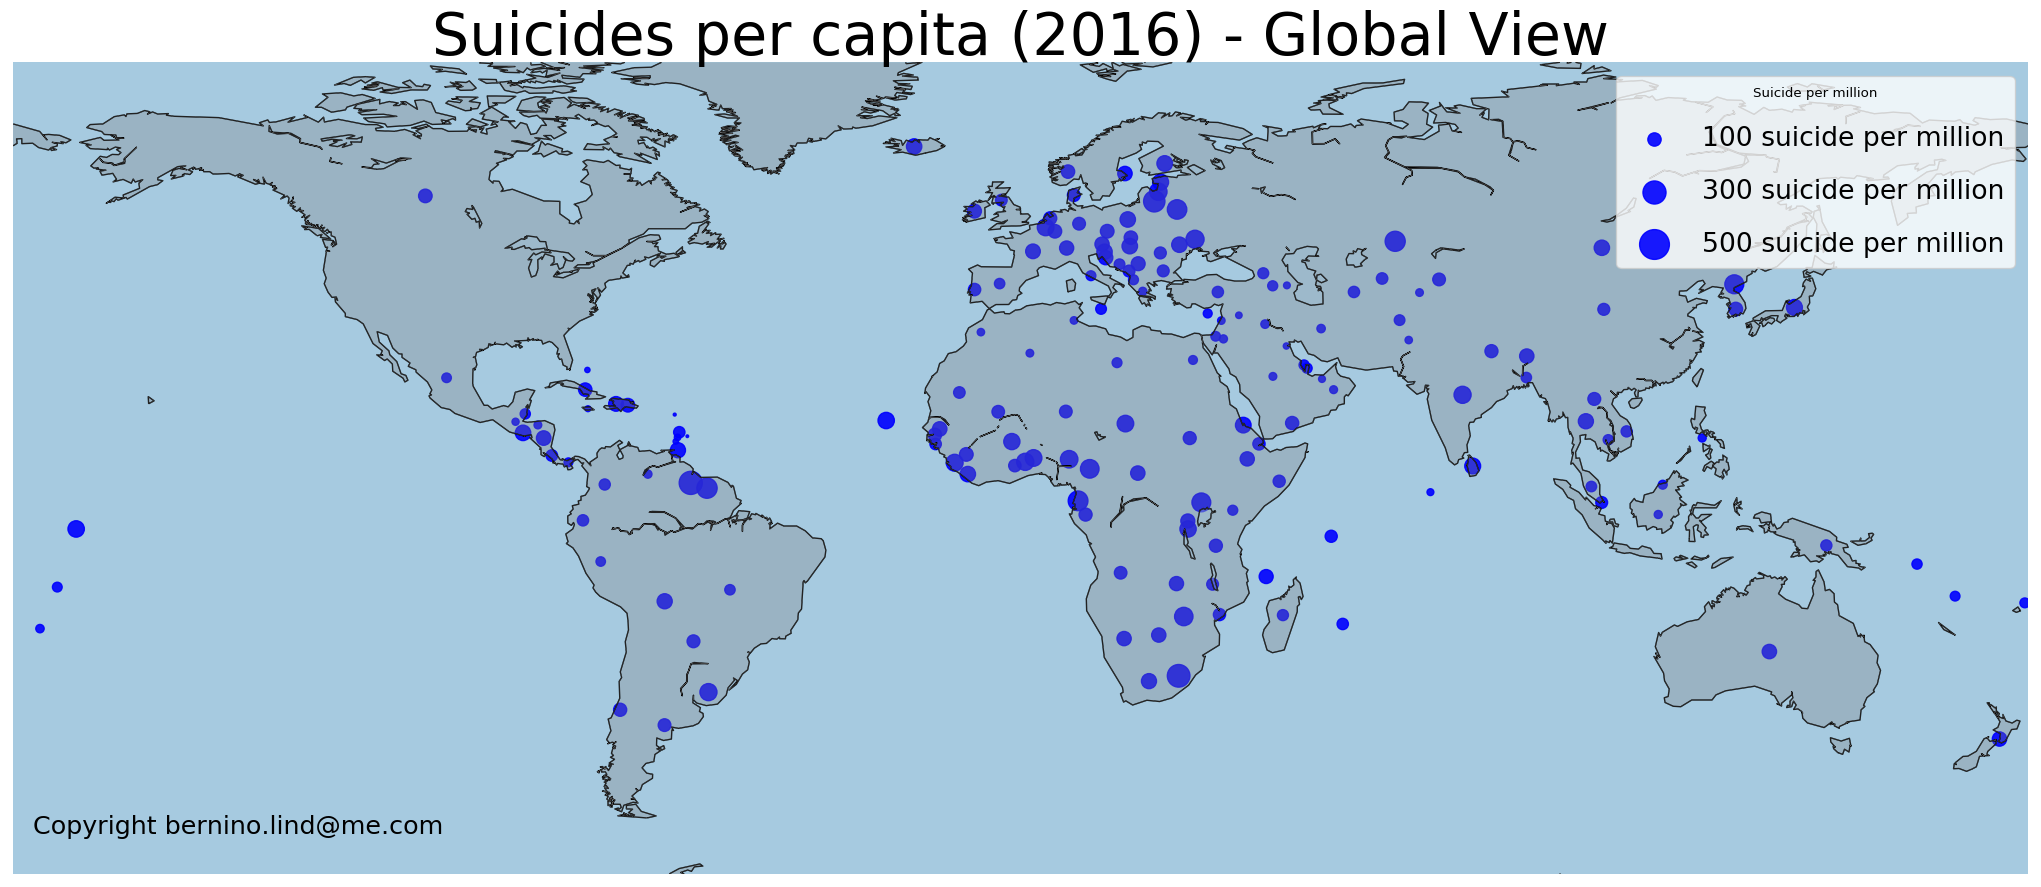

In [10]:
# Needed to quickly change map projection
lats = dfc['latitude'].tolist()
lons = dfc['longitude'].tolist()
sui = dfc['2016']*10
sui = sui.tolist()

# Nice and big map 
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
# if we are not in same ortho we must project...
x, y = m(lons, lats)
m.drawcoastlines()
m.scatter(x, y, s=sui, alpha=0.9, c='blue', cmap='viridis')
#m.scatter(x, y, s=sui, alpha=0.9, c='blue', cmap='viridis')
#m.shadedrelief()
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
#m.drawcountries(linewidth = 1)
plt.title('Suicides per capita (2016) - Global View', size=44)
#plt.legend(loc=1,  prop={'size': 24})
plt.annotate('Copyright bernino.lind@me.com', xy=(0.01, 0.05), xycoords='axes fraction', size=19)
for area in [100, 300, 500]:
    m.scatter([], [], c='blue', alpha=0.9, s=area, cmap='viridis',
                label=str(area) + ' suicide per million')
plt.legend(loc=1, scatterpoints=1, frameon=True, labelspacing=1, title='Suicide per million', prop={'size':20})

plt.show()

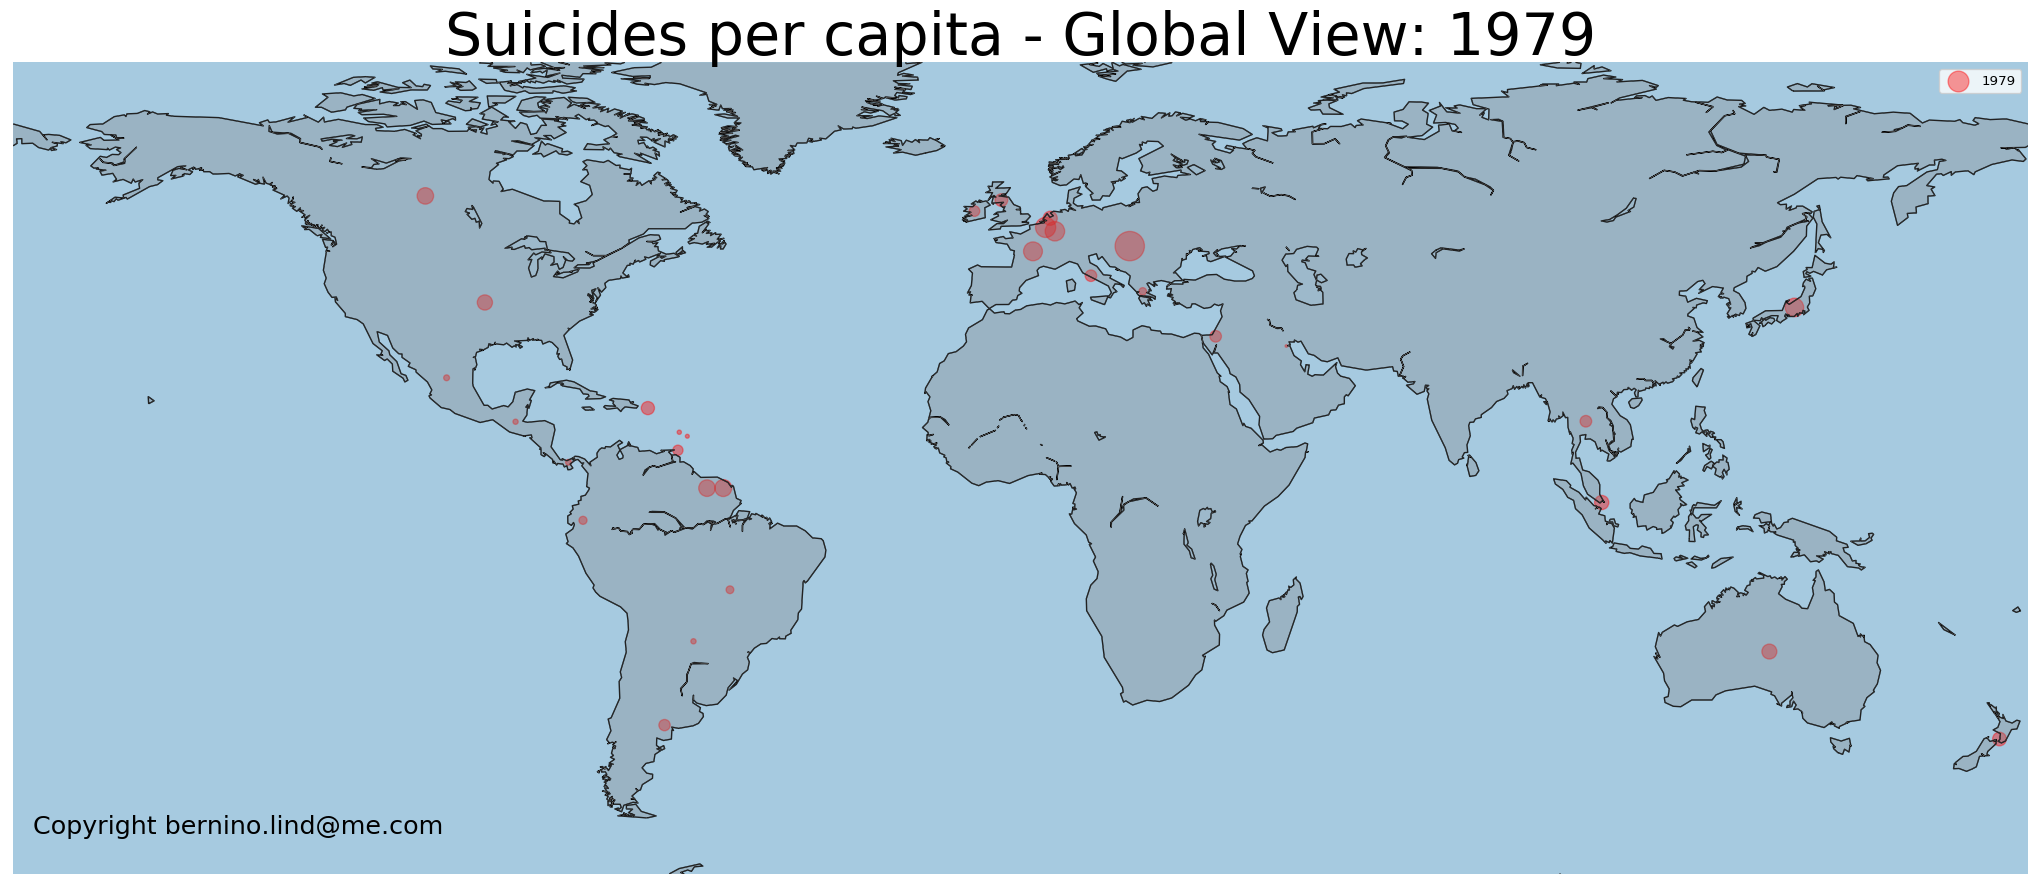

In [29]:
# lets do the yearly suicide per capita as animation

# recreating the dataframe with suicides per capita, country and year
sccc = suicide.groupby(['country','year'])['suicides_no', 'population'].sum()
sccc = sccc.reset_index()
sccc['suicidecap'] = sccc.apply(lambda row: row['suicides_no'] / row['population'], axis=1)
sccc['suicidecap'] =  sccc['suicidecap'] * 100000  
sccc = pd.DataFrame(sccc)

# adding lat/lon
sccc = pd.merge(sccc, countrycodes, left_on = ['country'], right_on = ['name'])
#print(sccc.head())

# Needed variables
# Nice and big map 
my_dpi=96
#fig = plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
fig, ax = plt.subplots(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)

# transfrom lat/lon to chosen projection

#setup map
m.drawcoastlines()
#m.shadedrelief()
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
#m.drawcountries(linewidth = 1)
plt.title('Suicides per capita - Global View', size=44)
plt.annotate('Copyright bernino.lind@me.com', xy=(0.01, 0.05), xycoords='axes fraction', size=19)
#m.scatter(x, y, s=sui, alpha=0.4, c='blue', cmap="Set1", label='Suicide per capita')

color = itertools.cycle(["r", "b", "g"])
#import matplotlib.cm as cm
#color=iter(cm.rainbow(np.linspace(0,1,15)))

# animation function.  This is called sequentially i += i and with frames iterations
def animate(i):
    global scat
    scat.remove()
    year = 1979+i
    title= 'Suicides per capita - Global View: ' + str(year)
    ax.set_title(title, size = 44)
    nn = sccc.loc[sccc['year'] == year]
    lons = nn['longitude'].tolist()
    lats = nn['latitude'].tolist()
    sui = nn['suicidecap']*10
    sui = sui.tolist()
    x, y = m(lons, lats)
    #scat = m.scatter(x, y, s=sui, alpha=0.4, c=next(colors), cmap="Set1", label=year)
    label = "Suicide per capita: "+str(year)
    scat = m.scatter(x, y, s=sui, alpha=0.4, c=next(color), cmap="Set1", label=year)
    plt.legend(loc=1,prop={'size': 10})
    plt.draw()

# call the animator.  blit=True means only re-draw the parts that have changed.
scat = m.scatter(0,0,s=0)
anim = animation.FuncAnimation(fig, animate, frames=38, interval=1500, repeat=True)
anim.save('suicides-per-year.mp4')

# East european cluster?!
There's certainly a cluster in east europe and into Russia ... what's going on in that part of the world?

# Merging suicide by country and location with happiness index
The Happiness index dataframe doesn't have the suicide per capita column nor geolocation so we can't do a correlation coefficient analysis of the data just yet nor any geoplots.

Merging the two dataframes.

In [12]:
# To merge amount of suicides with happiness index we need dataframe of suicides by country
mergeDf = pd.merge(happy, countrieswithsc, left_on = ['Country (region)'], right_on = ['name'])
print(mergeDf.head())


mergeDfc = pd.merge(happy, dfc, left_on = ['Country (region)'], right_on = ['Country'])
print(mergeDfc.head())

  Country (region)  Ladder  SD of Ladder  Positive affect  Negative affect  \
0          Finland       1             4             41.0             10.0   
1          Denmark       2            13             24.0             26.0   
2           Norway       3             8             16.0             29.0   
3          Iceland       4             9              3.0              3.0   
4      Netherlands       5             1             12.0             25.0   

   Social support  Freedom  Corruption  Generosity  Log of GDP\nper capita  \
0             2.0      5.0         4.0        47.0                    22.0   
1             4.0      6.0         3.0        22.0                    14.0   
2             3.0      3.0         8.0        11.0                     7.0   
3             1.0      7.0        45.0         3.0                    15.0   
4            15.0     19.0        12.0         7.0                    12.0   

   Healthy life\nexpectancy  suicidecap country   latitude  lo

# Careful - some countries not merged
These below countries are either not matched from the newly created countries/location/suicides dataframe to happiness index dataframes because they're not in the happiness index or named with different country spelling. 

Will clean up the data with fuzzy matching for best fits.

In [13]:
# dataframe with countries in suicidecountry but not in happy dataframe
df4 = countrieswithsc.loc[~countrieswithsc['name'].isin(happy['Country (region)'])].copy()
print("countries not in happiness index but in suicides:")
print(df4[['name','suicidecap']])

countries not in happiness index but in suicides:
                         name  suicidecap
3          Russian Federation   32.527773
17                     Guyana   19.098840
18                   Suriname   18.407339
21                       Cuba   16.537065
34   United States of America   12.872719
36                 San Marino   12.136178
44              French Guiana   10.113139
45     Bosnia and Herzegovina    9.956976
48                 Guadeloupe    9.066655
49                Puerto Rico    8.875354
50                 Martinique    8.859144
57                      Macau    7.791263
60                   Kiribati    7.434541
62                 Seychelles    7.043415
64                      Aruba    6.637735
67                    Bermuda    5.900167
69                Saint Lucia    5.612150
71                     Belize    4.616805
77                       Fiji    3.707911
83                   Barbados    2.765490
91                    Grenada    1.704999
93                    Baha

In [14]:
#Using the happiness index named countries as the correct names since we know that worked on geolocation
correct_names=happy['Country (region)'].values
wrong_names=df4['name'].values

for row in wrong_names:
# fuzzy matching magic
    x=process.extractOne(row, correct_names)
    if x[1] > 79 :
        print("wrong name:"+row)
        print("correct name:"+x[0])
        print("score:"+str(x[1]))
        print("")
#        # update suicidecountry['name'] with correct name
#        # foreach loc where row has the exact keyname update to new key
#        # we can use build in dataframe searching
        countrieswithsc.loc[countrieswithsc['name'] == row, 'name'] = x[0]
        print(countrieswithsc[countrieswithsc['name'].str.contains(x[0])])

#print(suicidecountry[suicidecountry['country'].str.contains("Russia")])
#print(happy[happy['Country (region)'].str.contains("Russia")])

# try again
# To merge amount of suicides with happiness index we need dataframe of suicides by country
#mergeDf2 = pd.merge(happy, suicidecountry, left_on = ['Country (region)'], right_on = ['country'])
mergeDf = pd.merge(happy, countrieswithsc, left_on = ['Country (region)'], right_on = ['name'])
print(mergeDf[mergeDf['name'].str.contains("Russia")])
print(mergeDf.head())

#df5 = suicidecountry.loc[~suicidecountry['country'].isin(happy['Country (region)'])].copy()
#print(df4)

# Merge suicide, location and happiness
#slh = pd.merge(countrieswithsc, happy, left_on = ['name'], right_on = ['Country (region)'])
#print(slh.head())

wrong name:Russian Federation
correct name:Russia
score:90

   suicidecap country  latitude   longitude    name
3   32.527773      RU  61.52401  105.318756  Russia
wrong name:United States of America
correct name:United States
score:90

    suicidecap country  latitude  longitude           name
34   12.872719      US  37.09024 -95.712891  United States
wrong name:Bosnia and Herzegovina
correct name:Bosnia and Herzegovina 
score:100

    suicidecap country   latitude  longitude                     name
45    9.956976      BA  43.915886  17.679076  Bosnia and Herzegovina 
wrong name:Dominica
correct name:Dominican Republic
score:90

    suicidecap country   latitude  longitude                name
94    1.053186      DM  15.414999 -61.370976  Dominican Republic
wrong name:Oman
correct name:Romania
score:90

    suicidecap country   latitude  longitude     name
35   12.681650      RO  45.943161  24.966760  Romania
99    0.388109      OM  21.512583  55.923255  Romania
   Country (region)  L

# Location explains suicide and happiness?
We see that suicides both nominal and per capita is explained by longitude (east-west) and surprisingly that longitude also explains "Positive effect" and Ladder (rank) of the happiness index. Latitude is also an explaining factor (the more north) for suicide and for higher ranking on the happiness index.

This is of course a mystery - how can happy countries also be suicidal?

One idea to search for : stress? Stress of poverty and stress of rich mans life...

## Lets plot suicide per capita with happiness index on a map
Wouldn't it be nice to plot the suicide per capita alongside the happiness index?

# Geomap and Rank of highly suicidal countries with happiness index
The Ladder is the global happiness rank.

Top suicidal countries:
    Country (region)  Ladder
129          Lesotho     144
39         Lithuania      42
56        Kazakhstan      60
73           Belarus      81
121           Uganda     136
87          Cameroon      96
131         Zimbabwe     146
119          Ukraine     133
76           Nigeria      85
49            Latvia      53
124             Togo     139
125            India     140
30           Uruguay      33
116     Sierra Leone     129
17           Belgium      18


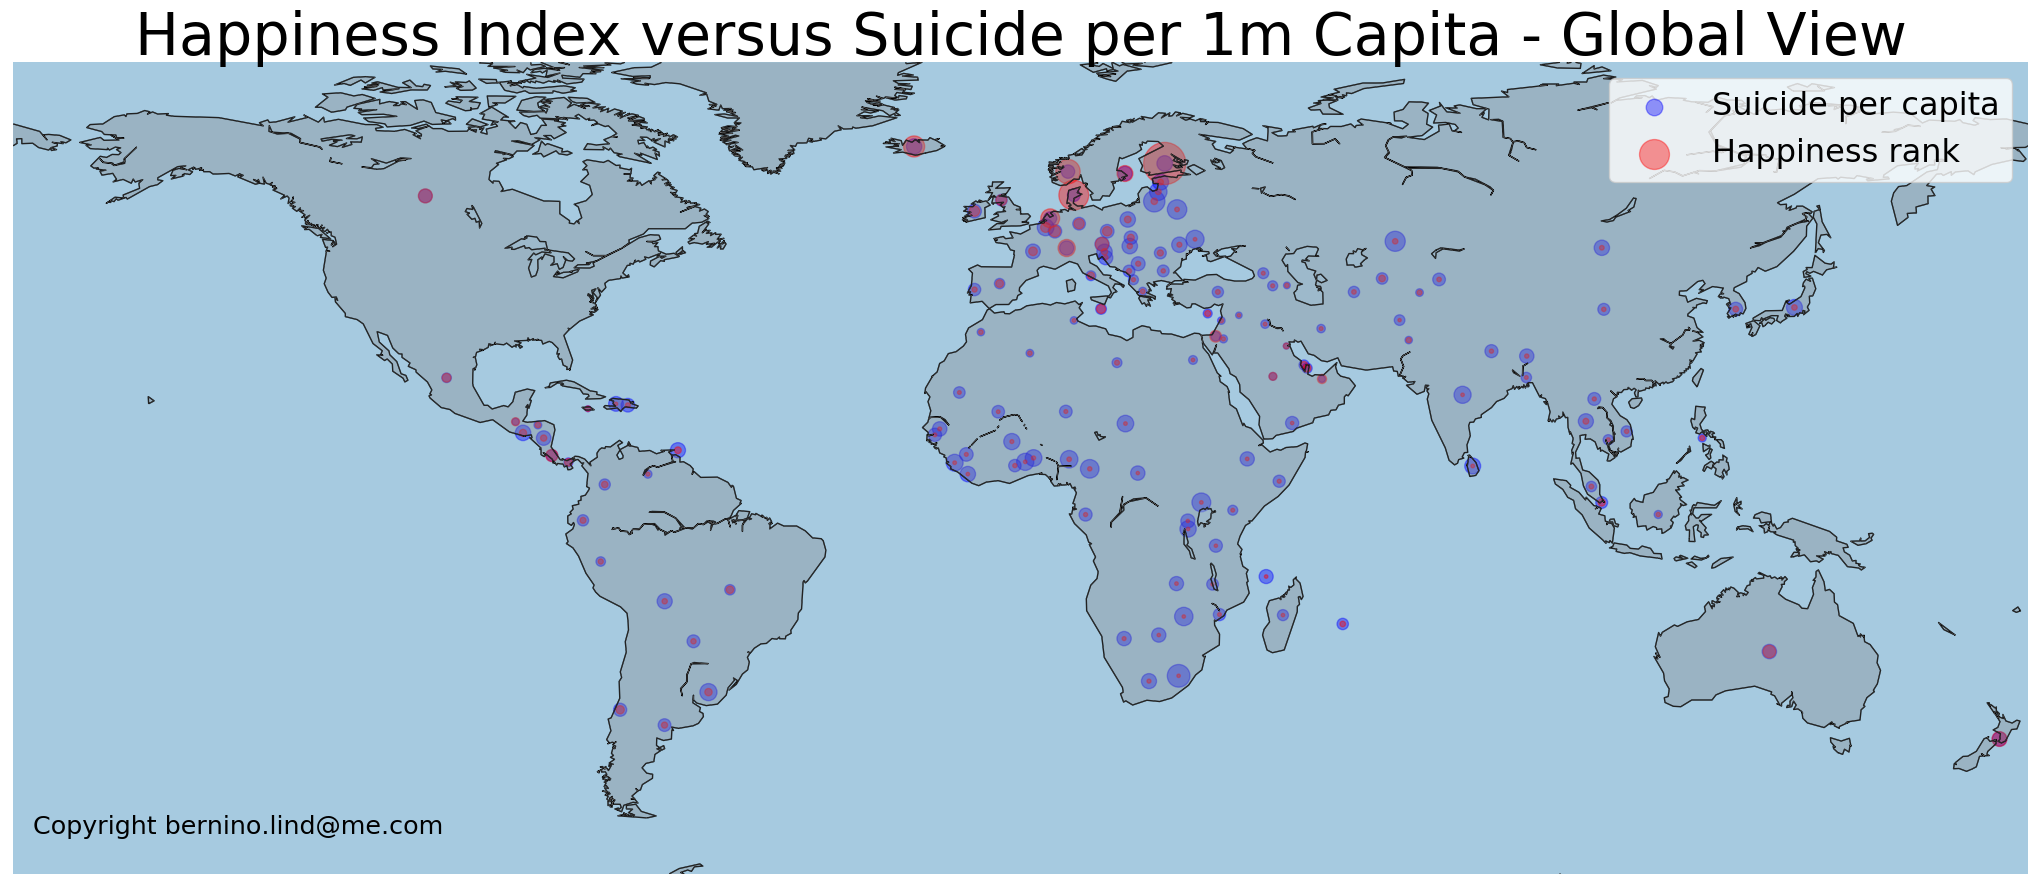

In [15]:
# Lets see a rank of suicidal countries with happiness index
ranked = mergeDfc.sort_values(by=['2016'],ascending=False)
print("Top suicidal countries:")
print(ranked[['Country (region)','Ladder']].head(15))

lats = mergeDfc['latitude'].tolist()
lons = mergeDfc['longitude'].tolist()
ladder = 1/mergeDfc['Ladder']*1000
ladder = ladder.tolist()
s = mergeDfc['2016']*10
s = s.tolist()

# Nice and big map 
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)

# if we are not in same ortho we must project...
x, y = m(lons, lats)
m.drawcoastlines()
m.scatter(x, y, s=s, alpha=0.4, c='blue', cmap="Set1", label='Suicide per capita')
m.scatter(x, y, s=ladder, alpha=0.4, c='red', cmap="Set1", label='Happiness rank')
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
plt.title('Happiness Index versus Suicide per 1m Capita - Global View', size=44)
plt.legend(loc=1,prop={'size': 24})
plt.annotate('Copyright bernino.lind@me.com', xy=(0.01, 0.05), xycoords='axes fraction', size=19)
#m.drawcountries(linewidth = 1)
#m.shadedrelief()
plt.show()

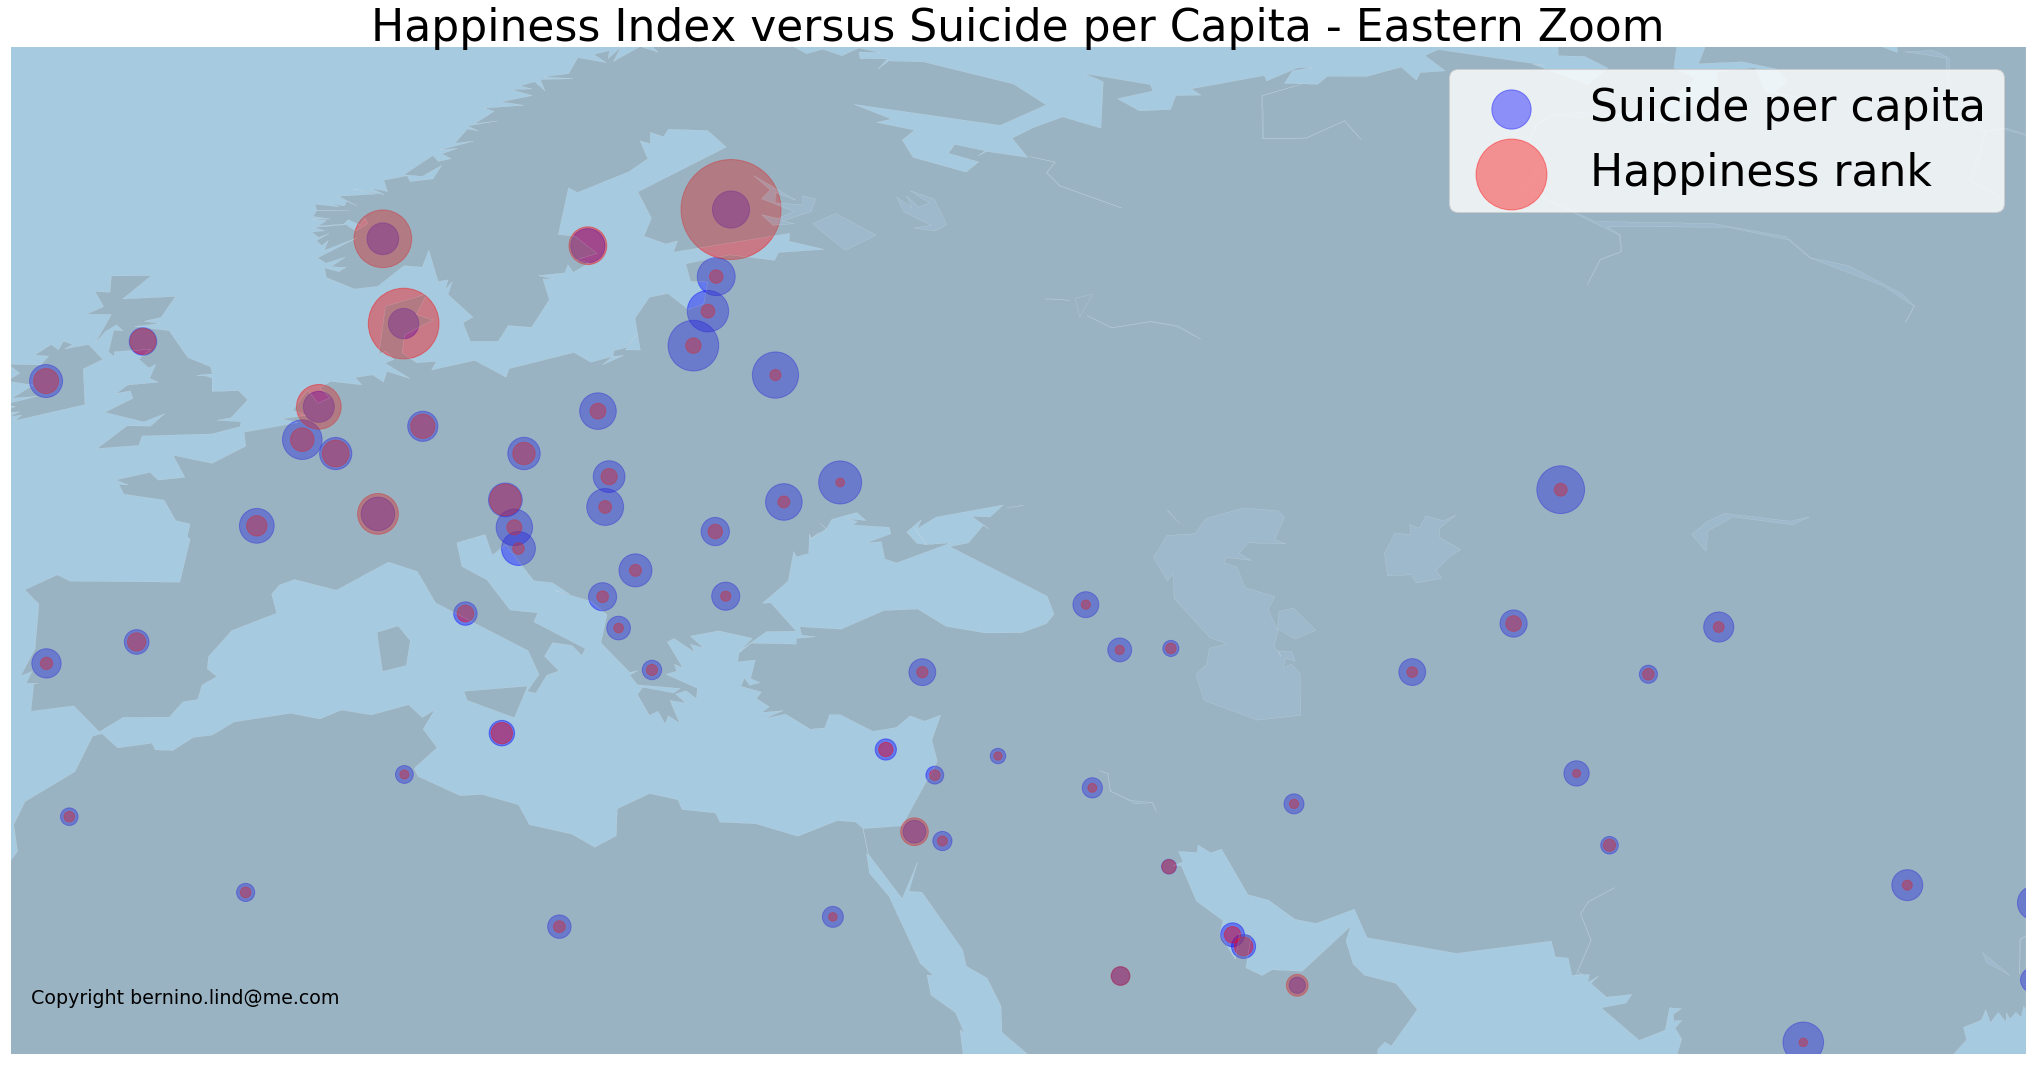

In [16]:
my_dpi=72
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
ladder = 1/mergeDfc['Ladder']*10000
ladder = ladder.tolist()
s = mergeDfc['2016']*100
s = s.tolist()

# map corners from:
# https://boundingbox.klokantech.com/ and https://ssmtdatta.github.io/basemap/
m2=Basemap(llcrnrlat=20,urcrnrlat=70, llcrnrlon=-10,urcrnrlon=90)
x, y = m2(lons, lats)
m2.scatter(x, y, s=s, alpha=0.4, c='blue', cmap="Set1", label='Suicide per capita')
m2.scatter(x, y, s=ladder, alpha=0.4, c='red', cmap="Set1", label='Happiness rank')
m2.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m2.fillcontinents(color='grey', alpha=0.3)
m2.drawcoastlines(linewidth=0.1, color="white")
plt.title('Happiness Index versus Suicide per Capita - Eastern Zoom', size=44)

plt.annotate('Copyright bernino.lind@me.com', xy=(0.01, 0.05), xycoords='axes fraction', size=19)
plt.legend(loc=1,prop={'size': 44})

plt.show()

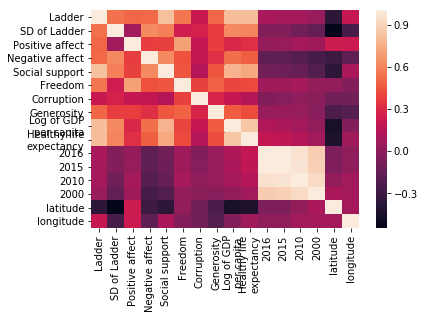

In [17]:
happycorr2 = mergeDfc.corr('pearson')
sns.heatmap(happycorr2)

# Conlclusion: Some happy countries are highly suicidal -- most are eastern european
Howerever there is a West African hotspot as well which isn't explored at this time and a MENA low which also isn't explored.

We see that even if some of the high ranking suicidal countries such as Russia are currently not merged into the happiness index -- it is peculiar that Finland is in there. Its suicidal rank is #10 followed by: #11 Austria, #12 Croatia, #13 Japan, #14 Belgium.

These countries could have their happiness described by social security, relatively high GDP/capita and a healthy life expectancy.

Finally there's clear evidence that something strange is going on with East European countries in the north. Suicide per capita is way too high.

## Ideas to explain abnormal suicide per capita?
Its mysterious how come they are abnormally suicidal - what is the stress or trend that merits this? Disappointments? Mental disorders? Food? Pollution? **Alcohol consumption?**

In [18]:
al = pd.read_csv('./data/alco.csv')

mergeAl = pd.merge(mergeDfc, al, left_on = ['Country (region)'], right_on = ['Entity'])
mergeAl=mergeAl.rename(columns={'Alcohol consumption (litres per capita) (liters of pure alcohol, projected estimates, 15+ years of age':'alco'})
print(mergeAl.sort_values(by=['alco'], ascending=False))
print(mergeAl.head())


    Country (region)  Ladder  SD of Ladder  Positive affect  Negative affect  \
65           Moldova      71            45            133.0             67.0   
39         Lithuania      42            55            138.0             41.0   
18    Czech Republic      20            20             74.0             22.0   
76           Nigeria      85           130             61.0             55.0   
16           Germany      17            17             65.0             30.0   
13        Luxembourg      14             3             62.0             19.0   
15           Ireland      16            34             33.0             32.0   
49            Latvia      53            30            119.0             38.0   
88          Bulgaria      97            47            117.0             13.0   
22            France      24            19             56.0             66.0   
41          Slovenia      44            54            114.0             71.0   
44           Romania      48            

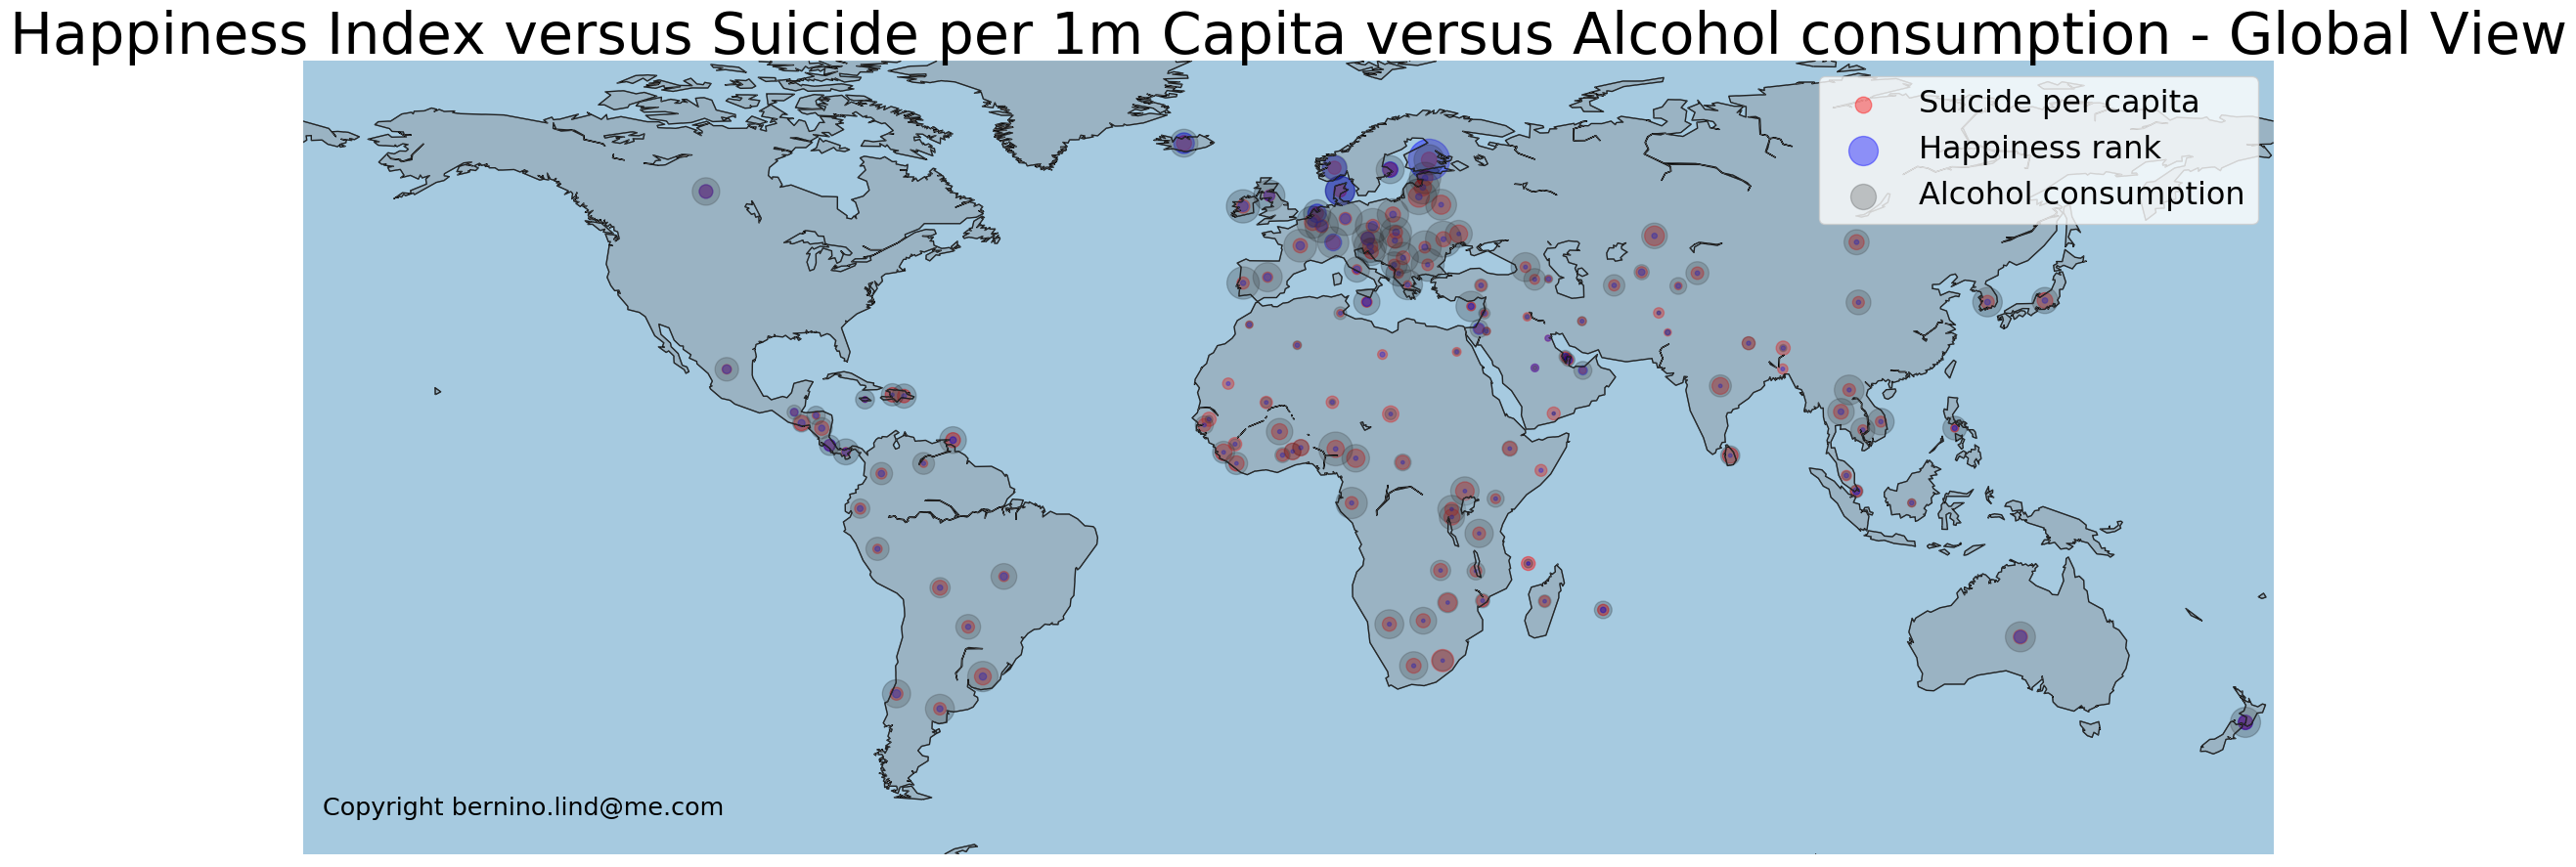

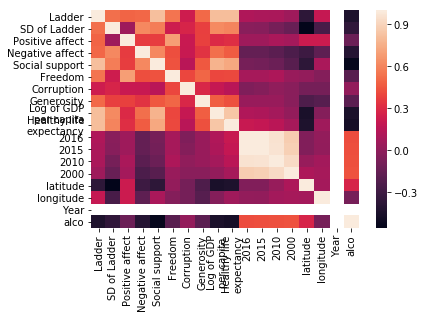

In [19]:

lats = mergeAl['latitude'].tolist()
lons = mergeAl['longitude'].tolist()
ladder = 1/mergeAl['Ladder']*1000
ladder = ladder.tolist()
s = mergeAl['2016']*10
s = s.tolist()
al = mergeAl['alco']*50
al = al.tolist()

# Nice and big map 
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)

# if we are not in same ortho we must project...
x, y = m(lons, lats)
m.drawcoastlines()
m.scatter(x, y, s=s, alpha=0.4, c='red', cmap="Set1", label='Suicide per capita')
m.scatter(x, y, s=ladder, alpha=0.4, c='blue', cmap="Set1", label='Happiness rank')
m.scatter(x, y, s=al, alpha=0.2, c='black', cmap="Set1", label='Alcohol consumption')
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
plt.title('Happiness Index versus Suicide per 1m Capita versus Alcohol consumption - Global View', size=44)
plt.legend(loc=1,prop={'size': 24})
plt.annotate('Copyright bernino.lind@me.com', xy=(0.01, 0.05), xycoords='axes fraction', size=19)
#m.drawcountries(linewidth = 1)
#m.shadedrelief()
plt.show()
happycorr3 = mergeAl.corr('pearson')
sns.heatmap(happycorr3)

# Alcohol consumption strongly correlated with suicides
Both in the map for intuitive exploration and more thoroughly in the correlation coefficient matrix we see that alcohol consumption is strongly correlated to suicide rates as the only explanatory variable.

In [20]:
#Choropleth using Geopandas

# read the shapefile and merge with the dataframe
# this should be our single source of truth - country codes
gp = gpd.read_file('data/ne_10m_admin_0_countries.shp')[['SOVEREIGNT', 'geometry', 'ADM0_A3']]
#print(gp.head())

# rather than using existing dataframes we rebuild everything
al = pd.read_csv('./data/alco.csv')
merged = gp.merge(al, left_on=['ADM0_A3'], right_on=['Code'])
#print(merged.describe())
#print(merged.head())
#print(list(merged))

# lets check all countries are loaded
diff = merged.loc[~merged['ADM0_A3'].isin(al['Code'])].copy()
#print("countries not in merged but in al:")
#print(diff[['ADM0_A3']])

# merge with suicide rates
#print(df.head())
alcosui = merged.merge(df, left_on=['Entity'], right_on=['Country'])
#print(alcosui.head())

corr = alcosui.corr()
print(corr)

      Year      alco      2016      2015      2010      2000
Year   NaN       NaN       NaN       NaN       NaN       NaN
alco   NaN  1.000000  0.359430  0.363007  0.369474  0.396943
2016   NaN  0.359430  1.000000  0.996240  0.965193  0.862337
2015   NaN  0.363007  0.996240  1.000000  0.971170  0.870726
2010   NaN  0.369474  0.965193  0.971170  1.000000  0.915641
2000   NaN  0.396943  0.862337  0.870726  0.915641  1.000000


# Alcohol to Suicide rate correlation
Is only a 0.4 correlation, though strong it isn't all that explanatory.

15.2


Text(0.1, 0.08, 'Copyright: bernino.lind@me.com')

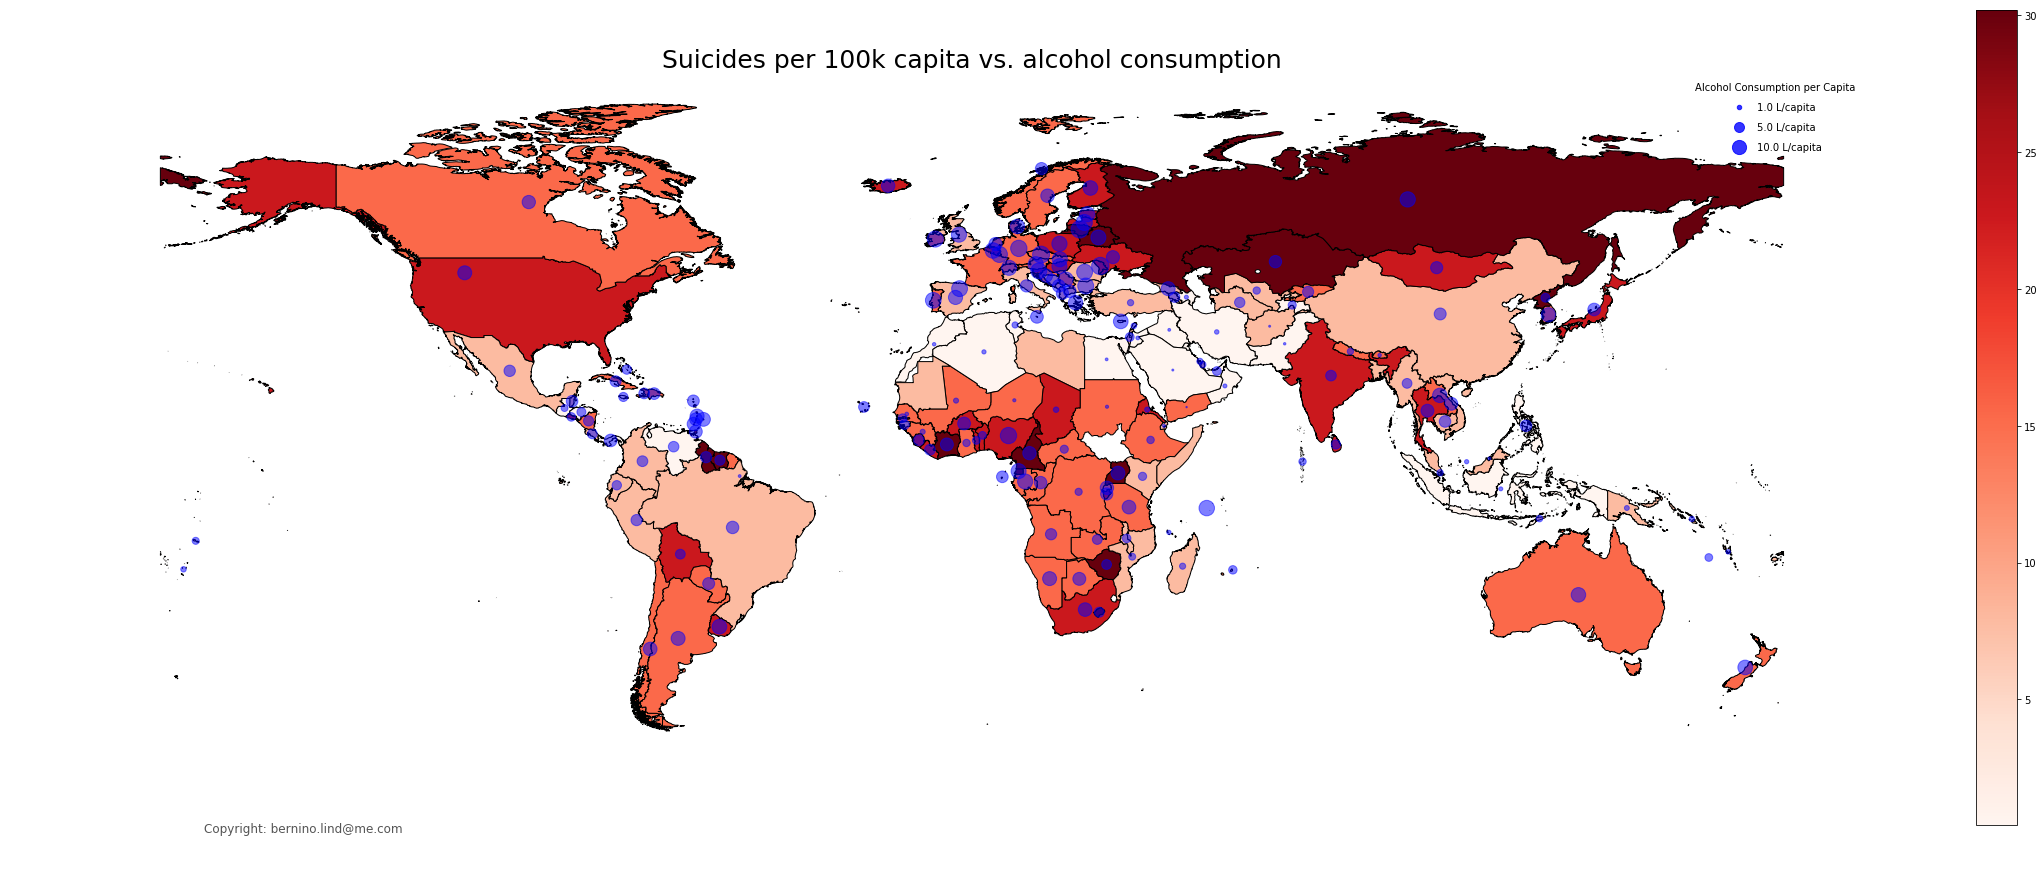

In [21]:
diff2 = df.loc[~df['Country'].isin(merged['Entity'])].copy()
#print("countries not in merged but in al:")
#print(diff2[['Country']])

# for plotting alcohol consumption with geo reference
# this is middle of countries
alcos = alcosui.copy()
alcos['geometry'] = alcos['geometry'].centroid
vmin = alcosui['2016'].min()
vmax = alcosui['2016'].max()
print(alcosui['alco'].max())

correct_names=merged['Entity'].values
wrong_names=diff2['Country'].values

# fuzzy matching magic
#for row in wrong_names:
#    print(row)
#    x=process.extractOne(row, correct_names)
#    if x[1] > 79 :
#        print("wrong name:"+row)
#        print("correct name:"+x[0])
#        print("score:"+str(x[1]))
#        print("")
        #countrieswithsc.loc[countrieswithsc['name'] == row, 'name'] = x[0]
        #print(countrieswithsc[countrieswithsc['name'].str.contains(x[0])])

# plotting

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax2 = plt.subplots(1, figsize=(40, 15))
#world.plot(color='lightgrey', linewidth=0.5, edgecolor='black')

# a legend for alco consumption
for area in [20, 100, 200]:
    ax2.scatter([], [], c='blue', alpha=0.8, s=area,
                label=str(area/20) + ' L/capita')

# plot the choropleth
p1 = alcosui.plot(column='2016', scheme='fisherjenks', ax=ax2, cmap='Reds', legend=True, label='Suicide per 100k capita', edgecolor='black')

# use the alcos copy to scatter plot the alcohol
# zoom with factor but divide with same in legend above
p2 = alcos.plot(ax=ax2, marker='o', color='blue', markersize=alcos['alco']*20, alpha=0.5)

# plot the legend
ax2.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Alcohol Consumption per Capita')

# legend for suicide rate
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

ax2.set_title("Suicides per 100k capita vs. alcohol consumption", fontsize=25)
ax2.set_axis_off()

ax2.annotate('Copyright: bernino.lind@me.com',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# High suicide - alcohol
Where suicide rates are high they generally also drink alcohol however there are places with high alcohol consumption that do not have high suicide rates. Finally where suicide rates are low they generally do not drink alcohol.

In [22]:
# choropleth the matplotlib way
# see https://ramiro.org/notebook/basemap-choropleth/